# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine learning (ML) is an appropriate solution for this problem because flight delays are caused by multiple factors such as weather, time of year, airport traffic, airline operations, and route distance. These relationships are complex for traditional rule-based or statistical models analyse and predict.
By learning from large volumes of historical flight performance data, an ML model can uncover hidden patterns that correlate with weather-related delays and accurate, data-driven predictions for future flights can be made. This enables the travel platform to provide real-time insights to customers, improving transparency and satisfaction.

### 2. Formulate the business problem, success metrics, and desired ML output.

#### Business Problem

Flight delays, especially those which are caused by weather can reduce customer satisfaction and create uncertainty. The travel booking platform wants to alert customers about the likelihood of weather-related delays before booking flights from or to the busiest U.S. airports.

#### Business Goal

Develop a predictive model that identifies flights likely to be delayed due to weather, allowing customers to make more informed booking decisions and airlines to plan better.

#### Success Metrics

- Primary metric: F1-score ≥ 0.85 (to balance precision and recall for weather delay detection)
- Secondary metrics:
    - Accuracy ≥ 85%
    - False Positive Rate ≤ 10% (to minimize unnecessary delay alerts)
    - ROC-AUC ≥ 0.90 (for model discrimination ability)

#### Desired ML Output

For each scheduled flight, the model should output:
- A binary prediction (1 = delayed due to weather, 0 = not delayed due to weather)
- A probability score representing the likelihood of a weather delay.

### 3. Identify the type of ML problem you’re dealing with.

This is a supervised learning problem. The model learns from labeled historical data where weather delay outcomes are known (WeatherDelay > 0).
It specifically represents a binary classification problem, where the goal is to classify each flight into one of two categories:

- Delayed due to weather, or
- Not delayed due to weather.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [4]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [11]:
zip_path = 'data_compressed'       # Folder containing all the ZIP files
base_path = '.'                    # The current folder (Final project) as the project root
csv_base_path = 'data_extracted'   # New folder to store extracted CSV files

# Create the output folder if it doesn't already exist
!mkdir -p {csv_base_path}

In [12]:
# How many zip files do we have? write a code to answer it.
# List all files ending with .zip
zip_files = [f for f in os.listdir(zip_path) if f.endswith('.zip')]

# Print the count
print("Number of ZIP files:", len(zip_files))

# Print the file names
for f in zip_files:
    print(f)


Number of ZIP files: 60
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_3.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_2.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_1.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_5.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_4.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_6.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.zip
On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_8.

#### Extract CSV files from ZIP files

In [13]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    full_zip_path = os.path.join(zip_path, file)
    zip2csv(full_zip_path, csv_base_path)

print("Files Extracted")

Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_3.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_2.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_1.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_5.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_4.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip 
Extracting data_comp

In [15]:
all_extracted_files = []
for root, dirs, files in os.walk(csv_base_path):
    for file in files:
        all_extracted_files.append(os.path.join(root, file))

print("Total number of extracted files (including subfolders):", len(all_extracted_files))


Total number of extracted files (including subfolders): 61


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [18]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}/readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [23]:
df_temp = pd.read_csv("./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv") # **ENTER YOUR CODE HERE**

**Question**: Print the row and column length in the dataset, and print the column names.

In [ ]:
df_shape = df_temp.shape# **ENTER YOUR CODE HERE**
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


In [29]:
print(df_temp.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'DOT_ID_Reporting_Airline',
       'IATA_CODE_Reporting_Airline', 'Tail_Number',
       ...
       'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID',
       'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff',
       'Div5TailNum', 'Unnamed: 109'],
      dtype='object', length=110)


**Question**: Print the first 10 rows of the dataset.  

In [25]:
# Enter your code here
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [30]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:# **ENTER YOUR CODE HERE**
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [31]:
# Enter your code here
del_columns = [col for col in df_temp.columns if 'Del' in col]
print(del_columns)

['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [46]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [33]:
df = df_temp
counts = pd.DataFrame({
    'Origin': df['Origin'].value_counts(),
    'Destination': df['Dest'].value_counts()
})

counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [34]:
counts.sort_values(by='Origin',ascending=False).head(15 )# Enter your code here

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes, using the available flight data, we can build a supervised machine learning classification model to predict whether a flight will be delayed.

#### Input (Features)

The model can use the following features (independent variables):

Flight schedule details: Year, Month, DayOfWeek, CRSDepTime, CRSArrTime
Airline information: Reporting_Airline
Route details: Origin, Destination, Distance
External factors: Season, time of day, and possibly weather patterns (if merged with weather data)

#### Output (Target Variable)

The target is a binary variable representing whether a flight is delayed or not.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [35]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    df = pd.DataFrame(columns=filter_cols)
    parts = []
    for path in csv_files:
        try:
            # Read only needed columns to save memory
            tmp = pd.read_csv(path, usecols=filter_cols, low_memory=False)
            # Apply subsetting
            for col, vals in zip(subset_cols, subset_vals):
                tmp = tmp[tmp[col].isin(vals)]
            if not tmp.empty:
                parts.append(tmp)
        except Exception as e:
            print(f"Skipping {path}: {e}")

    if parts:
        df = pd.concat(parts, ignore_index=True)
    # Save combined file
    df.to_csv(file_name, index=False)
    return df

In [36]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [40]:
start = time.time()

combined_csv_filename = f"{base_path}/combined_files.csv"

# < write code to call the combined_csv function>
# List of extracted CSV files
csv_files = [
    os.path.join(csv_base_path, f)
    for f in os.listdir(csv_base_path)
    if f.endswith('.csv')
]
# Call the combine_csv() function
combined_df = combine_csv(
    csv_files=csv_files,
    filter_cols=cols,
    subset_cols=subset_cols,
    subset_vals=subset_vals,
    file_name=combined_csv_filename
)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

csv's merged in 2.7 minutes


In [41]:
combined_df.shape

(1658130, 20)

#### Load dataset

Load the combined dataset.

In [42]:
data = pd.read_csv(f"{base_path}/combined_files.csv")# Enter your code here to read the combined csv file.

Print the first 5 records.

In [43]:
# Enter your code here 
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,ArrDelay,ArrDelayMinutes,ArrDel15,Cancelled,Diverted,AirTime,Distance,DistanceGroup
0,2014,4,10,1,3,2014-10-01,AA,DFW,TX,SFO,CA,755,-9.0,0.0,0.0,0.0,0.0,195.0,1464.0,6
1,2014,4,10,2,4,2014-10-02,AA,DFW,TX,SFO,CA,755,40.0,40.0,1.0,0.0,0.0,199.0,1464.0,6
2,2014,4,10,3,5,2014-10-03,AA,DFW,TX,SFO,CA,755,9.0,9.0,0.0,0.0,0.0,196.0,1464.0,6
3,2014,4,10,4,6,2014-10-04,AA,DFW,TX,SFO,CA,755,-16.0,0.0,0.0,0.0,0.0,195.0,1464.0,6
4,2014,4,10,5,7,2014-10-05,AA,DFW,TX,SFO,CA,755,-8.0,0.0,0.0,0.0,0.0,192.0,1464.0,6


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [45]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", data['Year'].unique())
print("The months covered in this dataset are: ", data['Month'].unique())
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014 2017 2018 2015 2016]
The months covered in this dataset are:  [10  2  1 11  3 12  4  6  7  5  8  9]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['AA', 'DL', 'WN', 'UA', 'OO']
The Origin airports covered are:  ['DFW', 'SFO', 'DEN', 'PHX', 'IAH', 'ATL', 'ORD', 'LAX', 'CLT']
The Destination airports covered are:  ['SFO', 'DFW', 'DEN', 'PHX', 'ORD', 'IAH', 'ATL', 'LAX', 'CLT']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [47]:
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True) # Enter your code here

In [48]:
print(data.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup'],
      dtype='object')


Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [49]:
# Enter your code here
# Check for null values in each column
null_counts = data.isnull().sum(axis=0)

# Display the result
print(null_counts)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
Cancelled                0
Diverted                 0
AirTime              22540
Distance                 0
DistanceGroup            0
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [50]:
### Remove null columns
data = data[~data['ArrDelay'].isnull() & ~data['AirTime'].isnull()]

Get the hour of the day in 24-hour time format from CRSDepTime.

In [51]:
# Get the hour of the day (in 24-hour format) from CRSDepTime
data['DepHourofDay'] = (data['CRSDepTime'] // 100).astype(int)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

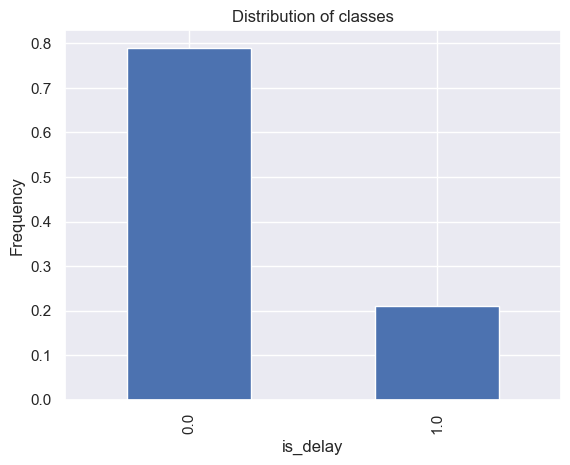

In [52]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

### Ans

From the bar graph of delay vs no delay we can see that,
- About 80% of flights (is_delay = 0) arrived on time or within 15 minutes of their scheduled arrival.

- Roughly 20% of flights (is_delay = 1) were delayed by more than 15 minutes.

This means that the dataset is imbalanced with significantly more "no delay" cases than "delay". This suggests that, The majority of flights operate as scheduled. During model training, special care should be taken to handle class imbalance.


**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

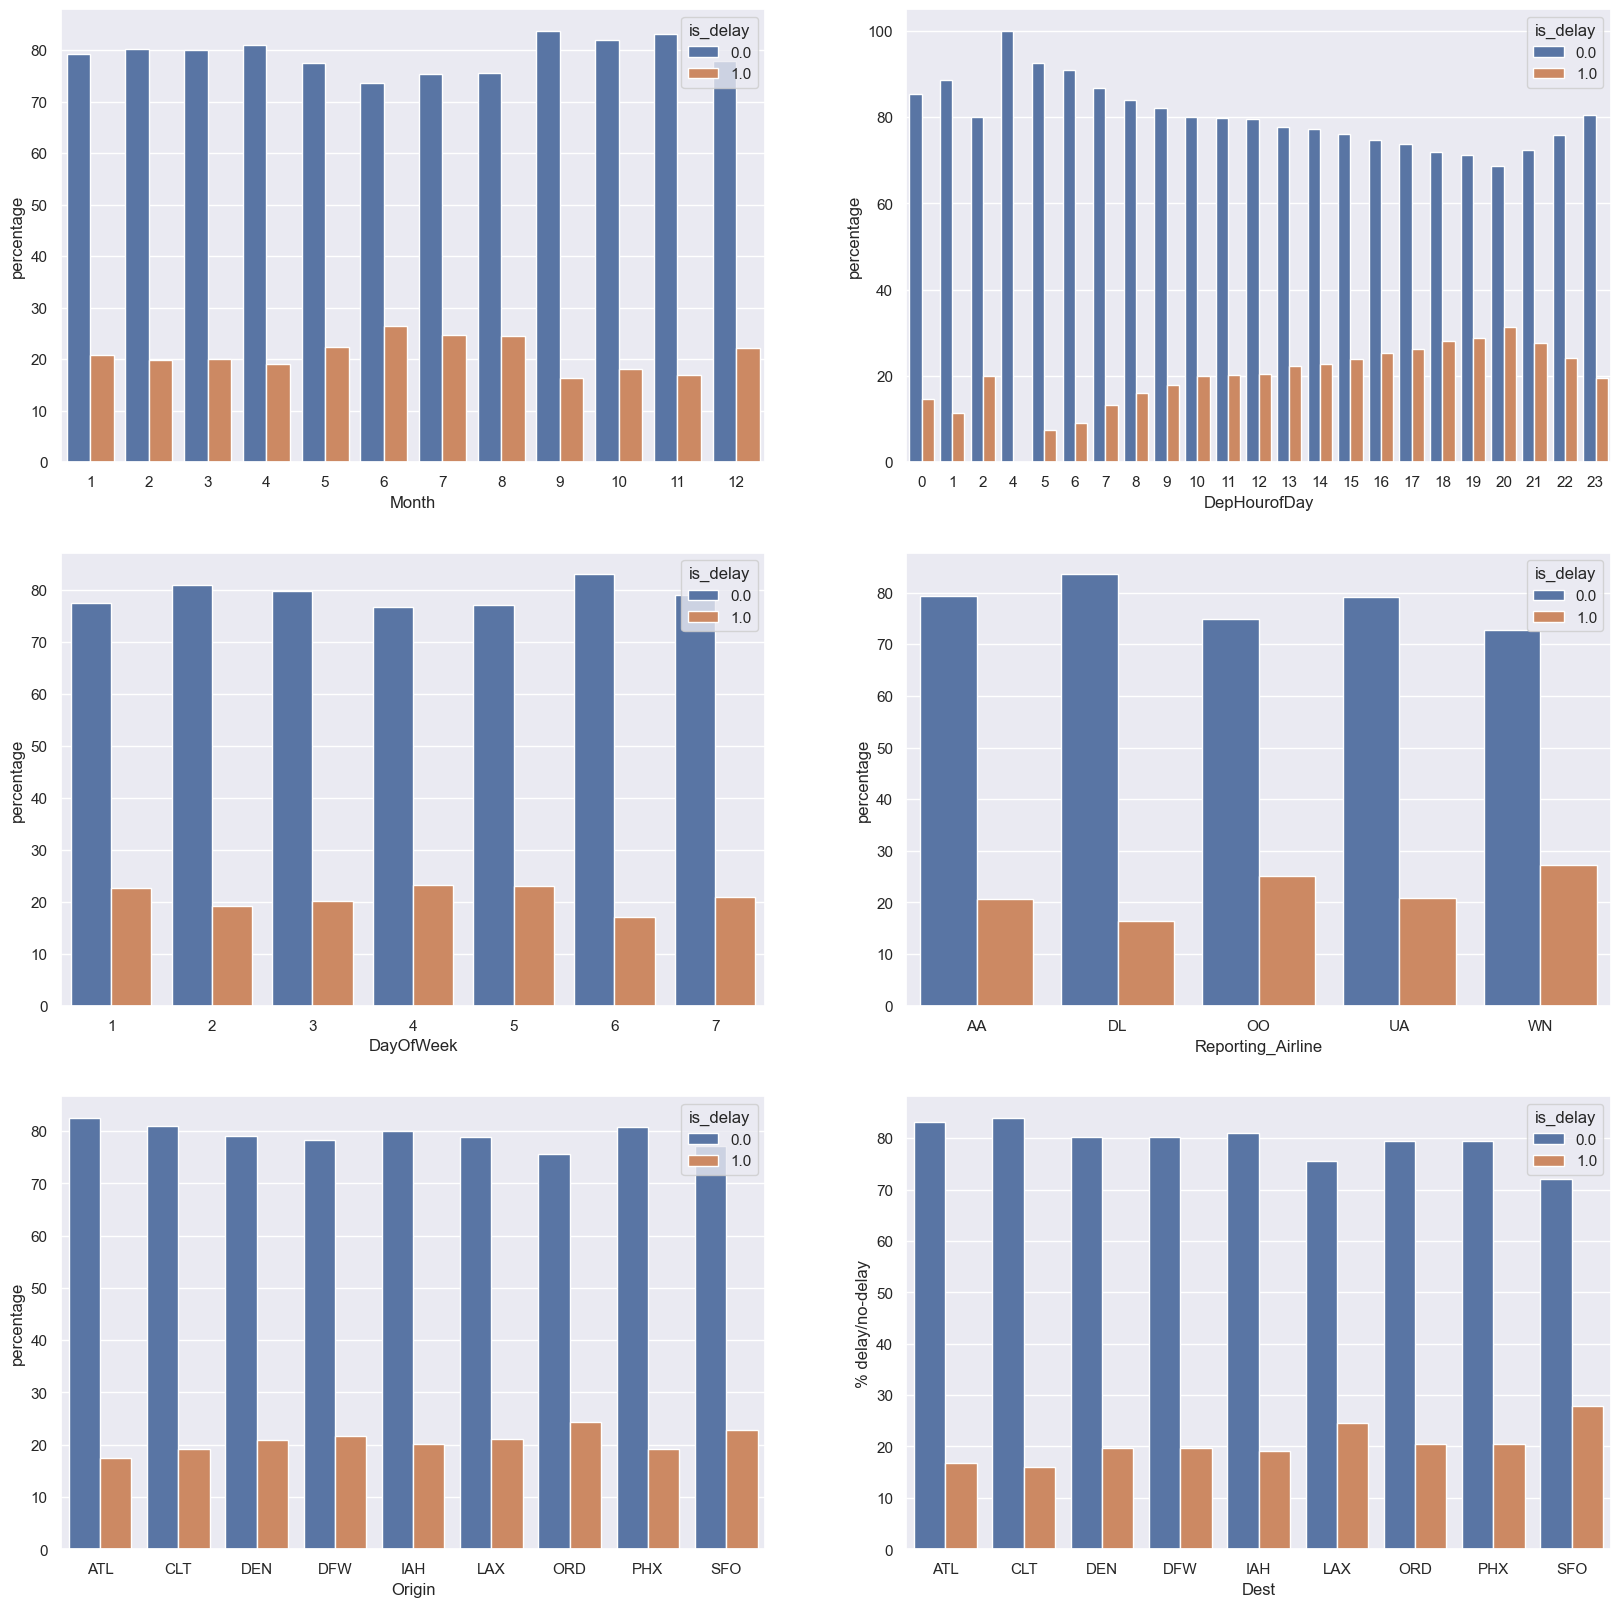

In [53]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

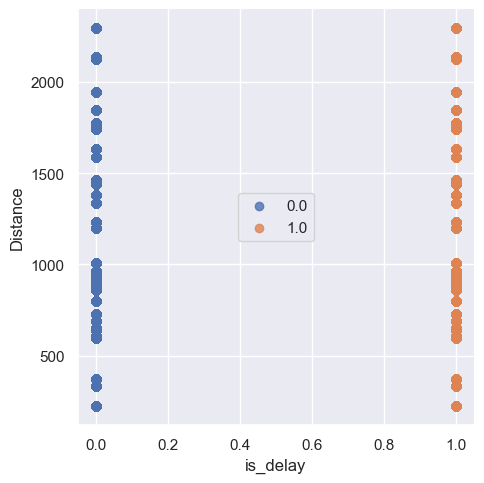

In [54]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

- Which months have the most delays?
    - The plots show slightly higher delay percentages during months (June–August) and December. So, June, July, August, and December have the most delays.
- What time of the day has the most delays?
    - The “DepHourOfDay” plot shows that flights later in the day (afternoon and evening) have higher delay percentages than early morning flights.
- What day of the week has the most delays?
    - Monday, Thursday, Friday and Sunday show the most delays.
- Which airline has the most delays?
    - SkyWest (OO) and Southwest (WN) experience the most delays.
- Which origin and destination airports have the most delays?
    - SFO and LAX have the most delays among both origin and destination airports.
- Is flight distance a factor in the delays?
    - The scatter plot of Distance vs. is_delay shows no strong trend. This suggests only distance is not a significant factor for predicting delays.

### Features

Look at all the columns and what their specific types are.

In [55]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup', 'DepHourofDay'],
      dtype='object')

In [56]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
Cancelled            float64
Diverted             float64
AirTime              float64
Distance             float64
DistanceGroup          int64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [57]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [58]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [59]:
data.shape

(1635590, 94)

In [60]:
data.columns

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [61]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [62]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B
data.to_csv('combined_csv_v1.csv', index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [63]:
from sklearn.model_selection import train_test_split
X = data.drop('target', axis=1)
y = data['target']
train_data, test_data, train_target, test_target = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (1308472, 93)
Testing set shape: (327118, 93)


### Baseline classification model

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# fit the model on the training data
model.fit(train_data, train_target)

# predict on the test data
y_pred = model.predict(test_data)

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [70]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['No Delay', 'Delay'])
    plt.yticks(tick_marks, ['No Delay', 'Delay'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.show()
    

In [67]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    fpr, tpr, _ = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    print("Accuracy:", metrics.accuracy_score(test_labels, target_predicted))
    print("Precision:", metrics.precision_score(test_labels, target_predicted))
    print("Recall:", metrics.recall_score(test_labels, target_predicted))
    tn, fp, fn, tp = confusion_matrix(test_labels, target_predicted).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

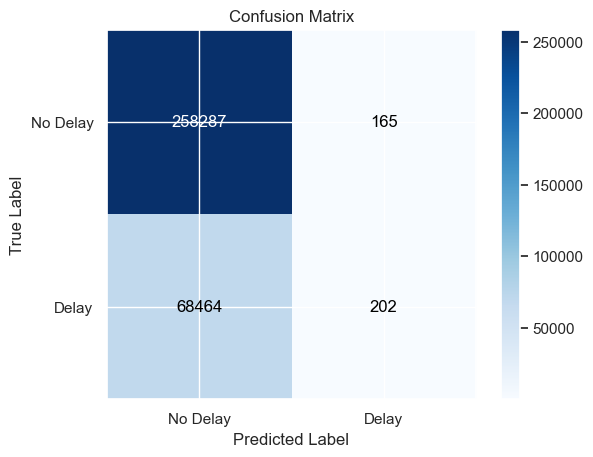

In [71]:
plot_confusion_matrix(test_target, y_pred)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

Accuracy: 0.7902010895150985
Precision: 0.5504087193460491
Recall: 0.0029417761337488715
Sensitivity: 0.0029417761337488715
Specificity: 0.9993615835822512


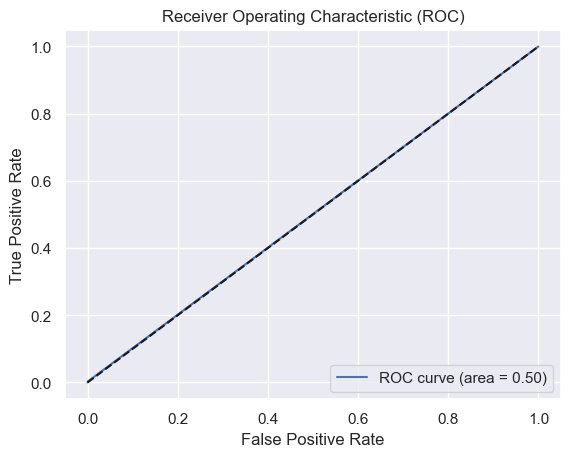

In [69]:
plot_roc(test_target, y_pred)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 
    
2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### Ans to Q1:
Test accuracy is 79% meaning the model is not overfitting. It generalizes reasonably well. However, even though accuracy is high, the ROC curve (AUC = 0.50) shows the model performs no better than random guessing in distinguishing delayed vs. non-delayed flights. 
Deduction: The model heavily predicts the majority class (“No Delay”) due to class imbalance. It achieves high accuracy simply by predicting “on time” for nearly every flight. That's why even thouh accuracy looks good, the model fails to detect actual delays.

#### Ans to Q2:
Accuracy: 0.7902010895150985 -> High, but misleading due to imbalance <br>
Precision: 0.5504087193460491 -> Of all predicted delays, only 55% were actual delays. <br>
Recall: 0.0029417761337488715 -> Extremely low — the model almost never identifies delayed flights.<br>
Specificity: 0.9993615835822512 -> Almost perfect at identifying non-delayed flights.

The class imbalance (far more “no delay” than “delay” cases) causes the model to bias toward predicting the majority class. Logistic regression without reweighting assumes balanced data, so it minimizes total errors by ignoring the minority class.
Thus:

Accuracy appears high, but

Recall and AUC reveal poor delay detection performance.

#### Ans to Q3:

From a business perspective, this model is not sufficient.
The goal is to warn customers about possible delays, so recall (sensitivity) is the key metric — we need to correctly flag delayed flights, even at the cost of a few false alarms.

- Next iteration suggestions (Feature Engineering stage):

1. Address class imbalance:

    - Apply class_weight='balanced' in Logistic Regression.

    - Use oversampling or undersampling methods.

2. Add or transform features:

    - Include weather features (temperature, precipitation, wind, etc.) since the business goal focuses on weather-related delays.

    - Engineer time-based buckets (e.g., peak vs. off-peak hours).

    - Add historical delay rates by airport and airline.


**Question**: What can you summarize from the confusion matrix?


#### Ans
The model correctly classified most non-delayed flights (TN = 258,287).

However, it missed the vast majority of actual delays (FN = 68,464), correctly identifying only 202 delayed flights out of tens of thousands.

This means it’s very accurate for “No Delay” predictions but very poor at detecting “Delay".

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [15]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [16]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [17]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [19]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [18]:
# write your answers here